In [1]:
import os
for dirname, _, filenames in os.walk('.'):
    print(dirname)

.
.\.git
.\.git\hooks
.\.git\info
.\.git\logs
.\.git\logs\refs
.\.git\logs\refs\heads
.\.git\logs\refs\remotes
.\.git\logs\refs\remotes\origin
.\.git\objects
.\.git\objects\00
.\.git\objects\01
.\.git\objects\02
.\.git\objects\03
.\.git\objects\04
.\.git\objects\05
.\.git\objects\06
.\.git\objects\07
.\.git\objects\08
.\.git\objects\09
.\.git\objects\0a
.\.git\objects\0b
.\.git\objects\0c
.\.git\objects\0d
.\.git\objects\0e
.\.git\objects\0f
.\.git\objects\10
.\.git\objects\11
.\.git\objects\12
.\.git\objects\13
.\.git\objects\14
.\.git\objects\15
.\.git\objects\16
.\.git\objects\17
.\.git\objects\18
.\.git\objects\19
.\.git\objects\1a
.\.git\objects\1b
.\.git\objects\1c
.\.git\objects\1d
.\.git\objects\1e
.\.git\objects\1f
.\.git\objects\20
.\.git\objects\21
.\.git\objects\22
.\.git\objects\23
.\.git\objects\24
.\.git\objects\25
.\.git\objects\26
.\.git\objects\27
.\.git\objects\28
.\.git\objects\29
.\.git\objects\2a
.\.git\objects\2b
.\.git\objects\2c
.\.git\objects\2d
.\.git\objects

In [2]:
images_path = 'E:\Data\CACD\data\CACD2000'

In [3]:
image_datas = os.listdir(images_path)

In [4]:
image_count = len(image_datas)
print(image_count)

152236


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import cv2
img = cv2.imread(os.path.join(images_path, image_datas[0]))
print(img.shape)

(250, 250, 3)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split, Dataset
import time
import copy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# torch.manual_seed(0)
# dataset = image_datas
# train_count = int(image_count * 0.9)
# test_count = 20
# val_count = image_count - train_count - test_count
# train_dataset, val_dataset, test_dataset = random_split(
#     dataset=dataset,
#     lengths=[train_count, val_count, test_count]
# )       
# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))
age_file_dic = {}
for file_name in image_datas:
    mark = file_name.split('_')[0]
    if mark in age_file_dic:
        age_file_dic[mark].append(file_name)
    else:
        age_file_dic[mark] = [file_name,]

In [9]:
import random
train_dataset, val_dataset, test_dataset = [], [], []
for age in age_file_dic.keys():
    age_files = age_file_dic[age]
    random.shuffle(age_files)
    train_dataset.extend(age_files[:-22])
    val_dataset.extend(age_files[-22:-2])
    test_dataset.append(age_files[-2:])
    

In [10]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

151356
800
40


In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), #随机水平翻转
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [12]:
from PIL import Image

age_class = {0:(21, 25), 1:(26,30), 2:(31, 35), 3:(36, 40), 4:(41, 45), 5:(46, 50), 6:(51, 55), 7:(56, 60)}
def split_age(age):
    for key in age_class.keys():
        if age_class[key][0] <= age <= age_class[key][1]:
            return key

class AgeGenderDataset(Dataset):
    def __init__(self, root_dir, mark):
        self.path_dir = root_dir
        self.transform = data_transforms[mark]
        self.img_files = train_dataset
        if mark == 'val':
            self.img_files = val_dataset
        # age: 21~~60
        self.ages = []
        self.images = []
        for file_name in self.img_files:
            age_gender_group = file_name.split("_")
            age_ = split_age(int(age_gender_group[0]))
            self.ages.append(age_)
            self.images.append(os.path.join(self.path_dir, file_name))

    def __len__(self):
        return len(self.ages)

    def __getitem__(self, index):
        image_path = self.images[index]
        age = self.ages[index]
        img = Image.open(image_path)
        transformed_img = self.transform(img)
        sample = {'image': transformed_img, 'lable': age}
        return sample

In [13]:
image_datasets = {x: AgeGenderDataset(images_path, x)
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [14]:
dataset_sizes

{'train': 151356, 'val': 800}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
device

device(type='cpu')

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

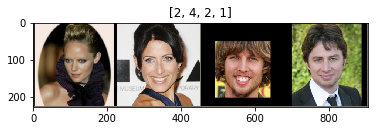

In [18]:
bath_data = next(iter(dataloaders['train']))
inputs, classes = bath_data['image'], bath_data['lable']
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes.tolist())

In [17]:
# model_file = './age_params.pkl'
# pretrained_dict = torch.load(model_file, map_location='cpu')

In [18]:
# pretrained_dict['fc.bias'].shape

torch.Size([2000])

In [19]:
class ResNet(nn.Module):
    """
    block: A sub module
    """
    def __init__(self, layers, num_classes=1000, model_path="age.pkl"):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.modelPath = model_path
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.stack1 = self.make_stack(64, layers[0])
        self.stack2 = self.make_stack(128, layers[1], stride=2)
        self.stack3 = self.make_stack(256, layers[2], stride=2)
        self.stack4 = self.make_stack(512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride = 1)
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)
        # initialize parameters
        self.init_param()

    def init_param(self):
        # The following is initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2./n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.shape[0] * m.weight.shape[1]
                m.weight.data.normal_(0, math.sqrt(2./n))
                m.bias.data.zero_()

    def make_stack(self, planes, blocks, stride = 1):
        downsample = None
        layers = []
            
        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
                )

        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for i in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stack1(x)
        x = self.stack2(x)
        x = self.stack3(x)
        x = self.stack4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [20]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [21]:
import math

model = ResNet([3, 4, 6, 3], 8)

In [22]:
# model.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [23]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 40)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            for i_batch, sample_batched in enumerate(dataloaders[phase]):
                inputs, labels = sample_batched['image'], sample_batched['lable']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, model_file)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [20]:
def visualize_model(model, num_batch=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, sample_batched in enumerate(dataloaders['val']):
            inputs, labels = sample_batched['image'], sample_batched['lable']
            inputs = torch.stack(inputs, dim=1)
            labels = torch.stack(labels, dim=1)
            images_so_far += 1
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            out = torchvision.utils.make_grid(inputs.cpu())
            imshow(out)
            print('真实值: ', " ".join('%s' % labels[j] for j in range(4)))
            print('预测值: ', " ".join('%s' % preds[j] for j in range(4)))

            if images_so_far == num_batch:
                model.train(mode=was_training)
                return
        model.train(mode=was_training)

In [21]:
model_ft1 = models.resnet18(pretrained=True)
num_ftrs = model_ft1.fc.in_features
model_ft1.fc = nn.Linear(num_ftrs, 8)
model_ft2 = models.vgg16(pretrained=True)
num_ftrs = model_ft2.classifier[6].in_features
model_ft2.classifier[6] = nn.Linear(num_ftrs, 8)
# model_ft1 = model.to(device)
model_ft1 = model_ft1.to(device)
model_ft2 = model_ft2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft1 = optim.SGD(model_ft1.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer_ft1, step_size=7, gamma=0.1)

optimizer_ft2 = optim.SGD(model_ft2.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)

In [22]:
from torchsummary import summary

summary(model_ft1, input_size=[(3, 224, 224)], batch_size=2, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2, 64, 112, 112]           9,408
       BatchNorm2d-2          [2, 64, 112, 112]             128
              ReLU-3          [2, 64, 112, 112]               0
         MaxPool2d-4            [2, 64, 56, 56]               0
            Conv2d-5            [2, 64, 56, 56]          36,864
       BatchNorm2d-6            [2, 64, 56, 56]             128
              ReLU-7            [2, 64, 56, 56]               0
            Conv2d-8            [2, 64, 56, 56]          36,864
       BatchNorm2d-9            [2, 64, 56, 56]             128
             ReLU-10            [2, 64, 56, 56]               0
       BasicBlock-11            [2, 64, 56, 56]               0
           Conv2d-12            [2, 64, 56, 56]          36,864
      BatchNorm2d-13            [2, 64, 56, 56]             128
             ReLU-14            [2, 64,

In [23]:
summary(model_ft2, input_size=[(3, 224, 224)], batch_size=2, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [2, 64, 224, 224]           1,792
              ReLU-2          [2, 64, 224, 224]               0
            Conv2d-3          [2, 64, 224, 224]          36,928
              ReLU-4          [2, 64, 224, 224]               0
         MaxPool2d-5          [2, 64, 112, 112]               0
            Conv2d-6         [2, 128, 112, 112]          73,856
              ReLU-7         [2, 128, 112, 112]               0
            Conv2d-8         [2, 128, 112, 112]         147,584
              ReLU-9         [2, 128, 112, 112]               0
        MaxPool2d-10           [2, 128, 56, 56]               0
           Conv2d-11           [2, 256, 56, 56]         295,168
             ReLU-12           [2, 256, 56, 56]               0
           Conv2d-13           [2, 256, 56, 56]         590,080
             ReLU-14           [2, 256,

In [24]:
model_file = './Age.pkl'
model_ft1 = train_model(model_ft1, criterion, optimizer_ft1, exp_lr_scheduler1,
                       num_epochs=50)

Epoch 1/50
----------
train Loss: 1.7889 Acc: 0.2650
val Loss: 1.6546 Acc: 0.3025

Epoch 2/50
----------
train Loss: 1.6357 Acc: 0.3186
val Loss: 1.6591 Acc: 0.3187

Epoch 3/50
----------
train Loss: 1.5799 Acc: 0.3397
val Loss: 1.5775 Acc: 0.3650

Epoch 4/50
----------
train Loss: 1.5369 Acc: 0.3567
val Loss: 1.5561 Acc: 0.3387

Epoch 5/50
----------
train Loss: 1.5000 Acc: 0.3730
val Loss: 1.5248 Acc: 0.3837

Epoch 6/50
----------
train Loss: 1.4657 Acc: 0.3874
val Loss: 1.5459 Acc: 0.3762

Epoch 7/50
----------
train Loss: 1.3027 Acc: 0.4645
val Loss: 1.5073 Acc: 0.3887

Epoch 8/50
----------
train Loss: 1.2478 Acc: 0.4907
val Loss: 1.4816 Acc: 0.4125

Epoch 9/50
----------
train Loss: 1.2104 Acc: 0.5073
val Loss: 1.4976 Acc: 0.4000

Epoch 10/50
----------
train Loss: 1.1730 Acc: 0.5247
val Loss: 1.5146 Acc: 0.4050

Epoch 11/50
----------
train Loss: 1.1327 Acc: 0.5417
val Loss: 1.5527 Acc: 0.4062

Epoch 12/50
----------
train Loss: 1.0916 Acc: 0.5597
val Loss: 1.5922 Acc: 0.3987

E

In [25]:
model_file = './Age_vgg16.pkl'
model_ft2 = train_model(model_ft2, criterion, optimizer_ft2, exp_lr_scheduler2,
                       num_epochs=50)

Epoch 1/50
----------
train Loss: nan Acc: 0.1273
val Loss: nan Acc: 0.1250

Epoch 2/50
----------


KeyboardInterrupt: 